# <center> <font color='blue'> PROJETO: Prevendo o Nível de Satisfação dos Clientes do Santander

![title](imagens/projeto.png)

<justify> Neste projeto iremos utilizar dados dos clientes do santander para avaliar o nível de satisfação dos mesmos, tais informações serão de grande utilizade para avaliação de campanhas capazes de aumentar o nível de satisfação de clientes insatisfeitos e manter a alta satisfação dos demais. O principal desafio a nossa frente é apresentar um modelo com acurácia superior a 70% para identificar clientes insatisfeitos.

## <center> <font color='blue'> FERRAMENTAS  

In [1]:
#Importando as bibliotecas a serem utilizadas

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
%reload_ext watermark
%watermark -a "Caio Brainer" --iversions

In [2]:
#Carregando os dados

#iremos carregar os dados em um df para realizar análise exploratória
df = pd.read_csv("datasets/train.csv")

## <center> <font color='blue'> ANÁLISE EXPLORATÓRIA DOS DADOS

In [3]:
#O dataset é constituido por 371 variáveis preditoras e 76020 observações

df.shape

(76020, 371)

In [4]:
#Cinco primeiras observações

df.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


<justify>O dataset apresenta um elevado número de variváveis (370), por isso usaremos técnicas de redução de dimensionalidade para poupar poder computacional e agilizar a análise.

In [5]:
#A variável ID presente no dataset não apresenta nenhuma informação relevante para a análise de satsfação, dito isto 
#iremos excluir

df = df.iloc[:,1:]
df.head()

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


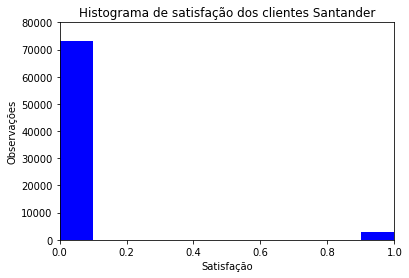

In [6]:
#Através do histograma da variável alvo podemos perceber que nossos dados são extremamente desbalanceados, devido a isso 
#teremos de utilizar técnicas como SMOTE ou atribuir pesos as classes a serem preditos

plt.hist(df["TARGET"], facecolor='b', alpha=1)

plt.xlabel('Satisfação')
plt.ylabel('Observações')
plt.title('Histograma de satisfação dos clientes Santander')
plt.xlim(0, 1)
plt.ylim(0, 80000)
plt.grid(False)
plt.show()